# Turbulence parameterizations

The cornerstone of parameterizing turbulence in weather and climate models is Monin-Obukhov similarity theory (MOST, @Monin1954). This theory is derived from the TKE equation, assuming stationarity and homogeneity (and neglecting pressure fluctuations), and states that all dimensionless turbulent quantities can be expressed in terms of the stability parameter $\zeta$. This has the consequence that subgrid-scale quantities, such as fluxes or turbulence intensities, can be parameterized (after normalization) in terms of static stability. Two MOST methods to parameterize fluxes are (1) flux-variance relations (used mainly in dispersion models) and (2) flux-profile relations (used in weather and climate models).

## Flux-variance relations
Flux-variance relations follow from MOST, and relate the (temporal) variance ($\sigma_x$) of a scalar ($x$) to its vertical flux ($\overline{w'x'}$) by

$$ \frac{\sigma_x}{x_*} = \Phi_x(\zeta) \quad \quad \textrm{with} \quad\quad x_* := \frac{\overline{w'x'}}{u_*}.  $$
Thereby, $\Phi_x(\zeta)$ is a stability correction function that accounts for diabatic processes. Under neutral conditions, the so called integral turbulence quantities, i.e. $\sigma_x/u_*$, are constant, so that there no stability correction is needed. 
When measuring fluxes and variances with the eddy-covariance method, the functions $\Phi_x(\zeta)$ can be fitted to the observations, and are assumed to have a certain "universality", so that they are transferable to other sites. This offers the possibility to then estimate the flux from the variance (and friction velocity and stability) by
$$ \overline{w'x'} = \frac{\sigma_x \, u_*}{\Phi_x(\zeta)}. $$

Even though stability correction functions show some "universality", recent studies found that the spread around stability correction function can be partly attributed to turbulence anisotropy (@Stiperski2018) and flow organization (@Mack2024), indicating that surface and flow properties are further important scaling parameters (additionally to $\zeta$), particularly over complex terrain. <br>
In Reddy, the variable $x_*$ can be calculated with `calc_xstar`, and scaling functions for horizontal velocity ($\Phi_u$, `scale_phiu`), vertical velocity ($\Phi_w$, `scale_phiw`), temperature ($\Phi_T$, `scale_phiT`) and passive scalar concentration ($\Phi_c$, `scale_phic`) from different studies are available.

### Example: Latent heat flux from flux-variance relation
Examplary, we calculate the latent heat flux using the flux-variance relation and compare it with the measured latent heat flux. As humidity is an 'almost' passive tracer, we use the scaling function for concentration (in Reddy `scale_phic`).

In [1]:
#loading Reddy package
#install.packages("../src/Reddy_0.0.0.9000.tar.gz",repos=NULL,source=TRUE,quiet=TRUE)
library(Reddy)
library(latex2exp)

#read in processed example data
dat=readRDS("../data/ec-data_30min_processed/processed_data_example.rds")

In [18]:
#calculate cov(h2o,w) from the flux variance relation
Phic=scale_phic(dat$zeta,1)
cov_h2ow_fv=dat$h2o_sd*dat$ustar/Phic/5


Call:
lm(formula = cov2lh(dat$cov_h2ow) ~ cov2lh(cov_h2ow_fv))

Residuals:
     Min       1Q   Median       3Q      Max 
-155.342  -14.557   -3.211   13.687   54.464 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         14.67877    2.63752   5.565 1.54e-07 ***
cov2lh(cov_h2ow_fv)  0.52684    0.04353  12.102  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23.27 on 124 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.5415,	Adjusted R-squared:  0.5378 
F-statistic: 146.4 on 1 and 124 DF,  p-value: < 2.2e-16


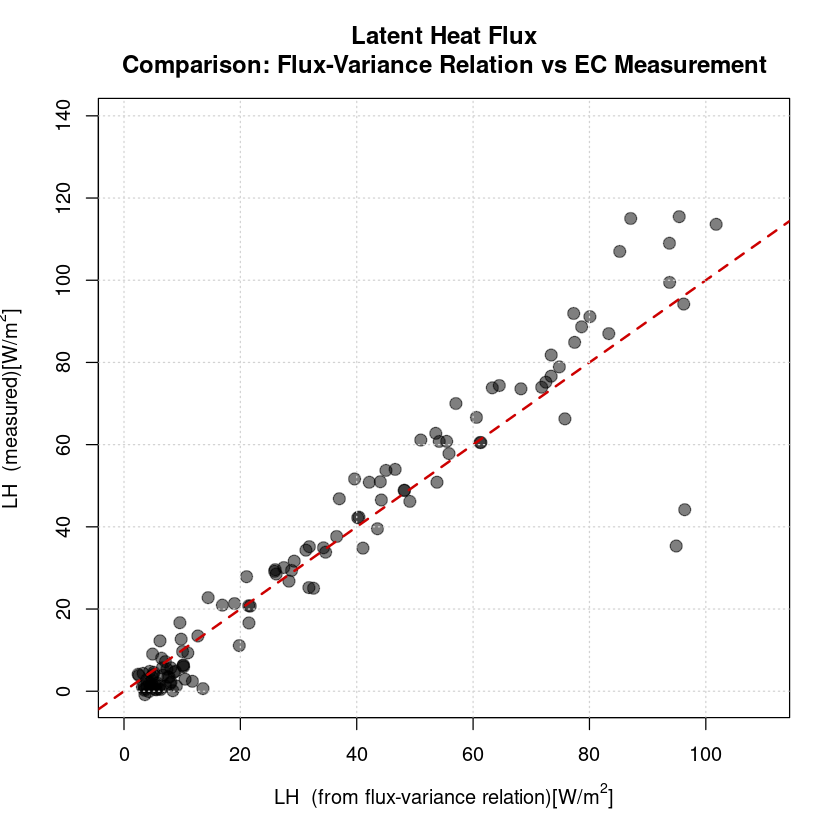

In [19]:
#compare flux-variance relation with measured latent heat flux
plot(cov2lh(cov_h2ow_fv),cov2lh(dat$cov_h2ow),pch=20,col=rgb(0,0,0,0.5),cex=2,xlim=c(0,110),
     xlab=TeX("LH [W/m$^2$] (from flux-variance relation)"),ylab=TeX("LH [W/m$^2$] (measured)"),
     main="Latent Heat Flux\nComparison: Flux-Variance Relation vs EC Measurement")
abline(0,1,col="red3",lwd=2,lty=2)
grid()
fit=lm(cov2lh(dat$cov_h2ow) ~ cov2lh(cov_h2ow_fv))
summary(fit) #R^2 = 0.987

We see, that the agreement is generally quite good but deteriorates at higher fluxes (convective conditions). Here, we used the variance from the high-frequency gas analyzer measurements, but the method is also applicable if the measurement frequency of the concentration is lower.

## Flux-profile relations and vertical profiles of temperature and wind speed
In numerical weather prediction or climate models, the fluxes between surface and atmosphere are parametrized in terms of the vertical gradient (bulk closure). The vertical gradients of wind speed and (potential) temperature can be calculated using flux-profile relations:

for wind speed/momentum:
$$ \frac{dU}{dz} = \frac{u_*}{\kappa z} \Phi_m(\zeta)$$
for temperature/heat:
$$ \frac{dT}{dz} = \frac{T_*}{\kappa z} \Phi_h(\zeta)$$

In Reddy, $\Phi_m$ and $\Phi_h$ can be calculated with `calc_phim, calc_phih` (from rearranging the above equations) or the respective scaling functions from literature, that are applied in NWP models, can be used by `scale_phim, scale_phih`. <br>
Integrating the flux-profile relations w.r.t. height allows to retrieve $U$ and $T$ as function of $z$:

wind speed profile:
$$ U(z) = \frac{u_*}{\kappa}( \ln(\frac{z}{z_0})-\Psi_m(\zeta)) $$
temperature profile:
$$ T(z) = T_0 + \frac{u_*}{\kappa}(\ln(\frac{z}{z_0})-\Psi_h(\zeta)) $$

Thereby, $\Psi_m$ and $\Psi_h$ are the integral forms of $\Phi_m$ and $\Phi_h$. With the function `calc_windprofile`, the vertical wind speed profile can be calculated using the above equation and the Businger-Dyer relation as scaling function. The example shows, that the wind speed increases faster with height under stable conditions (due to less eddy viscosity) given the same friction velocity.

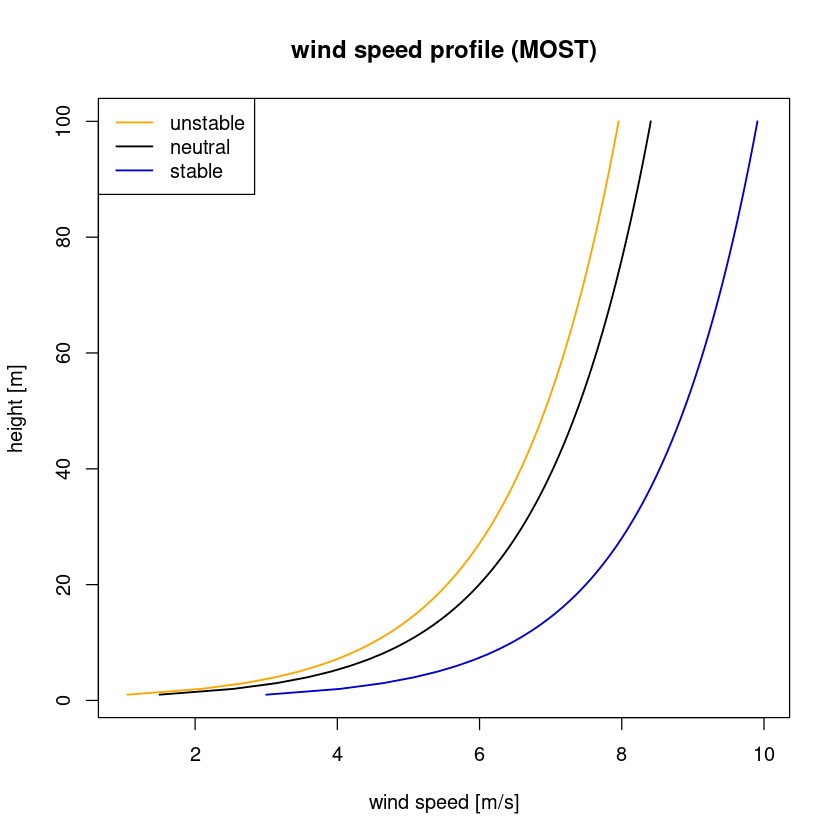

In [5]:
#calculate vertical wind speed profile
u_neutral=calc_windprofile(1:100,ustar=0.6)
u_unstable=calc_windprofile(1:100,ustar=0.6,zeta=-0.2)
u_stable=calc_windprofile(1:100,ustar=0.6,zeta=0.2)
#plot
plot(u_neutral$windspeed,u_neutral$height,type="l",lwd=1.5,xlab="wind speed [m/s]",ylab="height [m]",
    main="wind speed profile (MOST)",xlim=c(1,10))
points(u_unstable$windspeed,u_unstable$height,type="l",lwd=1.5,col="orange")
points(u_stable$windspeed,u_stable$height,type="l",lwd=1.5,col="blue3")
legend("topleft",legend=c("unstable","neutral","stable"),col=c("orange",1,"blue3"),lty=1,lwd=1.5)

## Using NWP model output
The Reddy package also provides functions to work with output from numerical weather prediction models, e.g. converting different types of vertical levels (e.g. `sigma2height, height2pres`), find closest grid points to station locations (`find_closest_grid_point`), calculate derivative (`df_dx,df_dy`) and to deaccumulate model fluxes (`deaccumulate1h`). By applying Taylor hypothesis, time differences can be converted to spatial differences using the function `dt2dx_taylor`. <br>
The stability parameter $\zeta$ (only requires point measurements) can be converted to Richardson number (usually used in NWP models) with the function `zeta2Ri` using the empirical relation

$$Ri(\zeta) = 0.74 \zeta \cdot \frac{\sqrt{1-15\zeta}}{\sqrt{1-9\zeta}}.$$

